In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import shutil
import zipfile
import os

In [13]:
# Base map
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Dowload PRIO-Grids and read shapefile
def get_prio_grids_shapefile(prio_grids_url):
    print("Fetching PRIO-Grids shapefile from:", prio_grids_url)
    response = requests.get(prio_grids_url)
    with open("priogrid_cell.zip", "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile("priogrid_cell.zip", "r") as zip_file:
        zip_file.extractall()
    os.remove("priogrid_cell.zip")
    prio_grids = gpd.read_file("priogrid_cell.shp")
    return prio_grids

prio_grids_url = "https://grid.prio.org/extensions/priogrid_cellshp.zip"
prio_grids = get_prio_grids_shapefile(prio_grids_url)

Fetching PRIO-Grids shapefile from: https://grid.prio.org/extensions/priogrid_cellshp.zip


In [18]:
# Get UCDP Candidate data from API
ucdp_api_url = "https://ucdpapi.pcr.uu.se/api/gedevents/23.0.2?pagesize=1000&page="
page = 0
data = []
while True:
    response = requests.get(ucdp_api_url + str(page))
    page_data = response.json()
    if not page_data['Result']:
        break
    data.extend(page_data['Result'])
    page += 1
ucdp_candidate = pd.DataFrame(data)

In [20]:
ucdp_candidate.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,462252,UKR-2023-1-14117-330,2023,True,Clear,1,13243,13243,Russia - Ukraine,14117,...,2023-02-01T00:00:00,2,0,0,0,2,8,2,365,369
1,462254,UKR-2023-1-14117-331,2023,True,Clear,1,13243,13243,Russia - Ukraine,14117,...,2023-02-01T00:00:00,0,0,4,0,4,4,4,365,369
2,462257,UKR-2023-1-14117-332,2023,True,Clear,1,13243,13243,Russia - Ukraine,14117,...,2023-02-01T00:00:00,0,0,4,0,4,4,4,365,369
3,462260,UKR-2023-1-14117-335,2023,True,Clear,1,13243,13243,Russia - Ukraine,14117,...,2023-02-01T00:00:00,0,0,1,0,1,1,1,365,369
4,462261,UKR-2023-1-14117-336,2023,True,Clear,1,13243,13243,Russia - Ukraine,14117,...,2023-02-02T00:00:00,0,0,1,0,1,2,1,365,369


In [21]:
# Filtering UCDP data and grouping by PRIO-GRIDs
ucdp_candidate = ucdp_candidate[(ucdp_candidate['where_prec'] <= 5) & (ucdp_candidate['best'] > 0)]
ucdp_cand_temp = ucdp_candidate.groupby(by=['priogrid_gid'])['best'].sum()

# Merging PRIO-GRID data and UCDP Candidate
merged_data = prio_grids.merge(ucdp_cand_temp, left_on="gid", right_on="priogrid_gid")


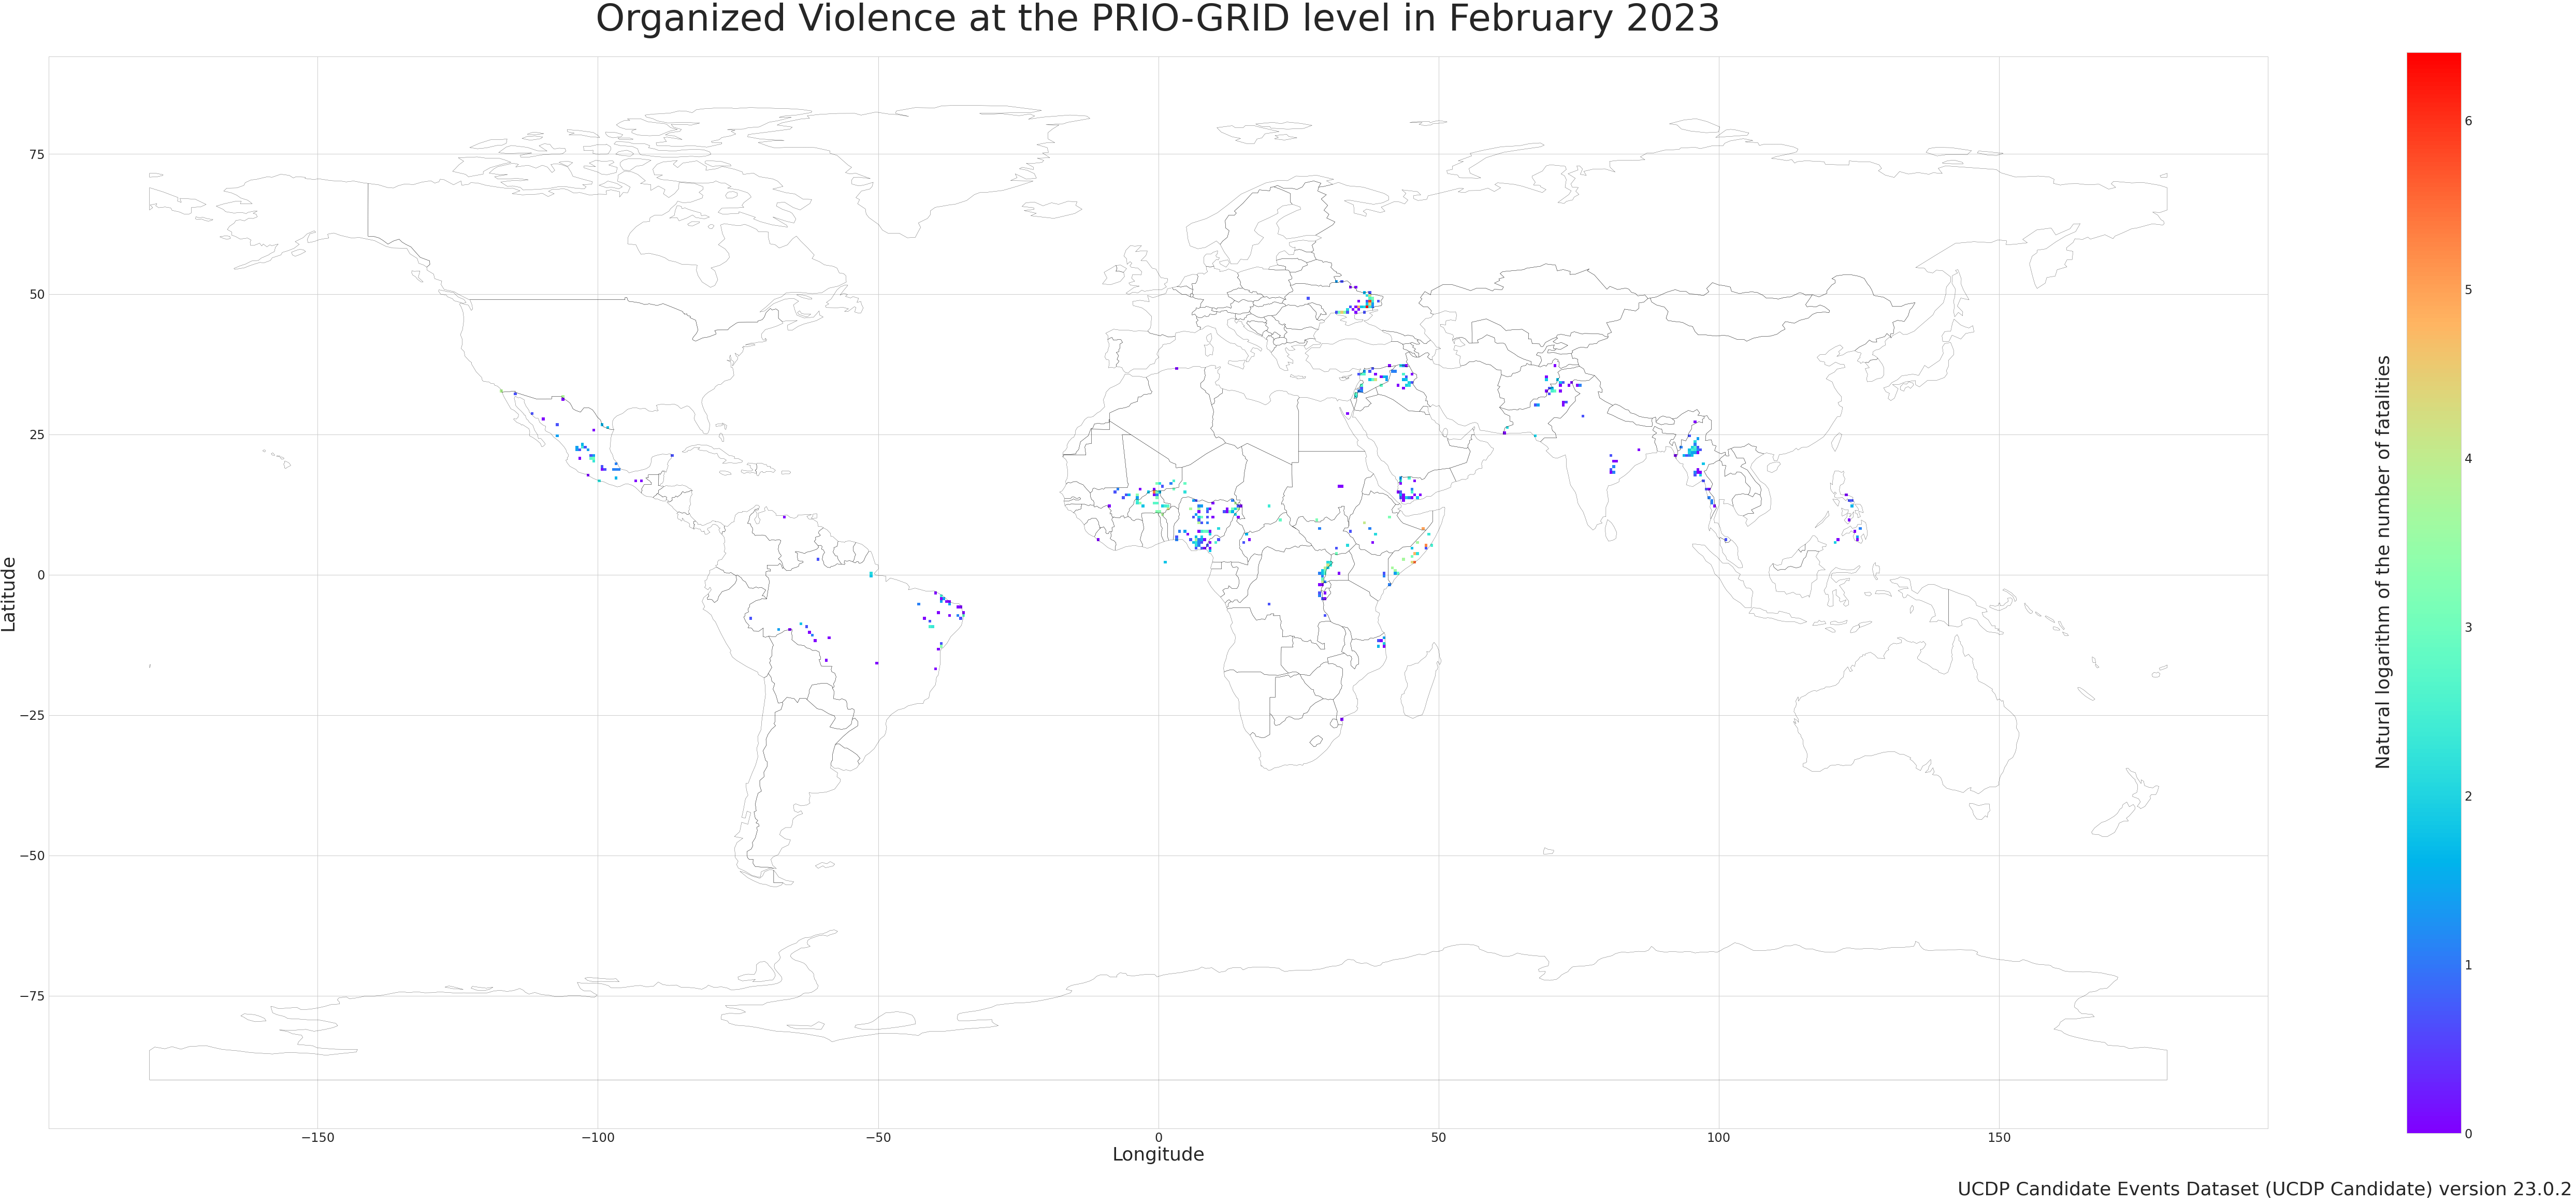

In [22]:
with plt.style.context(("seaborn", "seaborn-whitegrid")):
    fig, ax1 = plt.subplots(figsize=(96, 64))

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    merged_data["log_best"] = np.log(merged_data["best"])
    merged_data.plot(column="log_best",
                     ax=ax1,
                     legend=True,
                     legend_kwds={'shrink': 0.60},
                     cmap=plt.cm.rainbow).figure.axes[1].tick_params(labelsize=24)
    ax1.set_title('Organized Violence at the PRIO-GRID level in February 2023', pad=50, size=72)
    ax1.set_ylabel('Latitude', fontsize=36)
    ax1.set_xlabel('Longitude', fontsize=36)

    world_map.plot(facecolor="none",
                   ax=ax1,
                   edgecolor="black")

    plt.figtext(0.78, 0.43, "Natural logarithm of the number of fatalities", rotation='vertical', ha="right", fontsize=36)
    plt.figtext(0.83, 0.25, "UCDP Candidate Events Dataset (UCDP Candidate) version 23.0.2", ha="right", fontsize=36)
    fig.savefig('GEDEvent_v23_0_2.pdf', bbox_inches='tight', pad_inches=5)